# EUR/USD Volatility Modeling with Lasso Regression

This notebook implements a volatility forecasting model using exponentially-weighted features and Lasso regression on EUR/USD minute-level OHLC data.

## 1. Setup and Imports

In [33]:
%pip install pandas matplotlib scikit-learn --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 2. Configuration

In [34]:
# Data configuration
BASE_PATH = r"data"
YEARS = range(2012, 2022)

# Model configuration
MINUTE_INTERVAL = 5
TIMEFRAME = 120
MAX_LAG = 200
TEST_SIZE = 0.2
LASSO_ALPHA = 0.1

# Lambda grid for exponential decay features
LAMBDA_GRID = np.array([
    0.001, 0.002, 0.005,
    0.01, 0.02, 0.03, 0.05, 0.07,
    0.1, 0.15, 0.2, 0.3, 0.5, 0.7,
    1.0, 2.0, 3.0, 5.0, 10.0
])

## 3. Data Loading

In [35]:
def load_eurusd_data(base_path, years):
    data_frames = []
    
    for year in years:
        file_path = os.path.join(base_path, f'DAT_ASCII_EURUSD_M1_{year}.csv')
        df = pd.read_csv(file_path, header=None, sep=';')
        data_frames.append(df)
    
    data = pd.concat(data_frames, ignore_index=True)
    data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    
    print(f"Loaded {len(data):,} rows")
    print(data.head())
    
    return data

In [10]:
raw_data = load_eurusd_data(BASE_PATH, YEARS)

Loaded 3,712,747 rows
          DateTime     Open     High      Low    Close  Volume
0  20120102 020000  1.29324  1.29381  1.29324  1.29332       0
1  20120102 020100  1.29326  1.29345  1.29275  1.29341       0
2  20120102 020200  1.29342  1.29344  1.29341  1.29343       0
3  20120102 020300  1.29342  1.29342  1.29335  1.29336       0
4  20120102 020400  1.29324  1.29347  1.29320  1.29346       0


## 4. Data Cleaning

In [ ]:
def identify_missing_timestamps(data):
    full_range = pd.date_range(
        start=data.index.min(),
        end=data.index.max(),
        freq='1min'
    )
    missing_timestamps = full_range.difference(data.index)
    
    print(f"Missing timestamps: {len(missing_timestamps):,}")
    
    return full_range, missing_timestamps


def remove_duplicate_timestamps(df):
    df_clean = df.copy()
    
    while True:
        dup_mask = df_clean['DateTime'].duplicated(keep=False)
        if not dup_mask.any():
            break
        
        to_remove = df_clean['DateTime'].duplicated(keep='first')
        count = to_remove.sum()
        print(f"Removing {count} rows with duplicate timestamps…")
        
        df_clean = df_clean.loc[~to_remove].reset_index(drop=True)
    
    return df_clean


def remove_all_consecutive_duplicates(df):
    df_clean = df.copy()
    
    while True:
        # Check for consecutive duplicates (matching previous row)
        prev_dup = (
            (df_clean['Open'] == df_clean['Open'].shift(1)) &
            (df_clean['High'] == df_clean['High'].shift(1)) &
            (df_clean['Low'] == df_clean['Low'].shift(1)) &
            (df_clean['Close'] == df_clean['Close'].shift(1))
        )
        
        # Check for consecutive duplicates (matching next row)
        next_dup = (
            (df_clean['Open'] == df_clean['Open'].shift(-1)) &
            (df_clean['High'] == df_clean['High'].shift(-1)) &
            (df_clean['Low'] == df_clean['Low'].shift(-1)) &
            (df_clean['Close'] == df_clean['Close'].shift(-1))
        )
        
        # Check for flat bars (no price movement)
        flat_bar = (
            (df_clean['Open'] == df_clean['High']) &
            (df_clean['Open'] == df_clean['Low']) &
            (df_clean['Open'] == df_clean['Close'])
        )
        
        is_duplicate = prev_dup | next_dup | flat_bar
        count = is_duplicate.sum()
        
        if count == 0:
            break
        
        print(f"Marking {count} duplicates and flat bars…")
        
        df_clean.loc[is_duplicate, ['Open', 'High', 'Low', 'Close']] = np.nan
        df_clean.loc[is_duplicate, 'Volume'] = 0
        df_clean.loc[is_duplicate, 'indicator'] = 1
    
    return df_clean


def clean_ohlc_data(raw_data):
    data = raw_data.copy()
    
    # Set DateTime as index
    data.set_index('DateTime', inplace=True)
    data.index = pd.to_datetime(data.index)
    
    # Identify missing timestamps and create complete time range
    full_range, _ = identify_missing_timestamps(data)
    
    # Create complete DataFrame and merge
    complete_df = pd.DataFrame(full_range, columns=['DateTime'])
    data_reset = data.reset_index()
    combined_df = pd.merge(complete_df, data_reset, on='DateTime', how='left')
    
    # Remove duplicate timestamps
    combined_df = remove_duplicate_timestamps(combined_df)
    
    # Remove consecutive duplicates and flat bars
    cleaned_data = def remove_all_consecutive_duplicates(combined_df)
    
    print(f"Final cleaned data: {len(cleaned_data):,} rows")
    
    return cleaned_data

In [12]:
cleaned_data = clean_ohlc_data(raw_data)
cleaned_data.head()

Missing timestamps: 1,545,772
Removing 180 rows with duplicate timestamps…
Marking 57130 duplicates and flat bars…
Final cleaned data: 5,258,339 rows


,DateTime,Open,High,Low,Close,Volume,indicator
0,2012-01-02 02:00:00,1.29324,1.29381,1.29324,1.29332,0.0,NaN
1,2012-01-02 02:01:00,1.29326,1.29345,1.29275,1.29341,0.0,NaN
2,2012-01-02 02:02:00,1.29342,1.29344,1.29341,1.29343,0.0,NaN
3,2012-01-02 02:03:00,1.29342,1.29342,1.29335,1.29336,0.0,NaN
4,2012-01-02 02:04:00,1.29324,1.29347,1.29320,1.29346,0.0,NaN


## 5. Volatility Calculation

In [13]:
def compute_volatility_measure(ohlc_data, vol_measure):
    """
    Calculate volatility using the specified method.
    
    Parameters
    ----------
    ohlc_data : pd.DataFrame
        OHLC data with Prev_Close_global and Log_Returns_global columns
    vol_measure : str
        One of 'Garman-Klass', 'Rogers-Satchell', or 'Close-to-Close'
        
    Returns
    -------
    pd.DataFrame
        DataFrame with 'V' (variance) column added
    """
    ohlc_data = ohlc_data.copy()
    k = 2 * np.log(2) - 1  # Garman-Klass constant
    
    if vol_measure == 'Garman-Klass':
        ohlc_data['V'] = (
            0.5 * (np.log(ohlc_data['High'] / ohlc_data['Low']) ** 2) -
            k * (np.log(ohlc_data['Close'] / ohlc_data['Open']) ** 2)
        )
    
    elif vol_measure == 'Rogers-Satchell':
        H = ohlc_data['High']
        L = ohlc_data['Low']
        C = ohlc_data['Close']
        P = ohlc_data['Prev_Close_global']
        ohlc_data['V'] = np.log(H/P) * np.log(H/C) + np.log(L/P) * np.log(L/C)
    
    elif vol_measure == 'Close-to-Close':
        ohlc_data['V'] = ohlc_data['Log_Returns_global'] ** 2
    
    else:
        raise ValueError(
            "Invalid volatility measure. Choose 'Garman-Klass', "
            "'Rogers-Satchell', or 'Close-to-Close'."
        )
    
    return ohlc_data


def setup_rvol_column(data, timeframe, vol_measure):
    """
    Compute realized volatility for each group.
    
    Parameters
    ----------
    data : pd.DataFrame
        OHLC data with group_id column
    timeframe : int
        Grouping timeframe in minutes
    vol_measure : str
        Volatility measure to use
        
    Returns
    -------
    pd.DataFrame
        DataFrame with realized volatility column
    """
    # Compute per-bar variance contributions
    v_by_group = data.groupby('group_id').apply(
        lambda grp: compute_volatility_measure(grp, vol_measure),
        include_groups=False
    )
    
    if isinstance(v_by_group, pd.DataFrame):
        v_series = v_by_group['V']
    else:
        v_series = v_by_group
    
    v_series = v_series.reset_index(level=0, drop=True)
    
    # Attach per-bar V
    df = data.copy()
    df['V'] = np.nan
    df.loc[v_series.index, 'V'] = v_series
    
    # Compute per-group statistics
    grp_stats = df.groupby('group_id')['V'].agg(sum='sum', count='count')
    print(grp_stats)
    
    grp_stats['n_minus_1'] = grp_stats['count']
    grp_stats['var'] = np.where(
        grp_stats['n_minus_1'] > 0,
        grp_stats['sum'],
        np.nan
    )
    
    # Compute annualized realized volatility
    col_name = f'RVol_{timeframe}min_{vol_measure}'
    rvol_per_group = np.sqrt(grp_stats['var'])
    annualized_rvol = rvol_per_group * np.sqrt(365 * 24 * 60 / timeframe)
    
    # Map back to rows
    df[col_name] = df['group_id'].map(annualized_rvol) * 100
    df['n_minus_1'] = df['group_id'].map(grp_stats['n_minus_1'])
    
    return df


def aggregate_by_group(rvol_df, vol_title):
    """
    Aggregate data by group_id.
    
    Parameters
    ----------
    rvol_df : pd.DataFrame
        DataFrame with realized volatility
    vol_title : str
        Name of volatility column
        
    Returns
    -------
    pd.DataFrame
        Aggregated DataFrame
    """
    if isinstance(rvol_df.index, pd.DatetimeIndex):
        rvol_df = rvol_df.reset_index()
    
    if not pd.api.types.is_datetime64_any_dtype(rvol_df['DateTime']):
        rvol_df['DateTime'] = pd.to_datetime(rvol_df['DateTime'])
    
    grouped = rvol_df.groupby('group_id')
    
    aggregated = grouped.agg({
        "DateTime": ["first", "last"],
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last",
        "Volume": "sum",
        "indicator": "sum",
        'n_minus_1': "mean",
    })
    
    # Compute mode of volatility
    mode_series = grouped[vol_title].apply(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
    aggregated[vol_title] = mode_series.values
    
    # Flatten column names
    aggregated.columns = [
        f"{col[0]}_{col[1]}" if col[1] else col[0]
        for col in aggregated.columns
    ]
    
    aggregated.rename(columns={
        'DateTime_first': 'StartDateTime',
        'DateTime_last': 'EndDateTime',
        'n_minus_1_mean': 'count'
    }, inplace=True)
    
    aggregated.reset_index(inplace=True)
    
    return aggregated


def add_returns_columns(data):
    """
    Add previous close and log returns columns.
    
    Parameters
    ----------
    data : pd.DataFrame
        Aggregated OHLC data
        
    Returns
    -------
    pd.DataFrame
        DataFrame with returns columns
    """
    data = data.copy()
    data['Prev_Close_global'] = data['Close_last'].shift(1)
    data['Prev_Close_global'] = data['Prev_Close_global'].fillna(data['Open_first'])
    data['Log_Returns_global'] = np.log(data['Close_last'] / data['Prev_Close_global'])
    return data


def calculate_realized_volatility(data, vol_measure, timeframe, vol_title):
    """
    Complete realized volatility calculation pipeline.
    
    Parameters
    ----------
    data : pd.DataFrame
        Cleaned OHLC data
    vol_measure : str
        Volatility measure to use
    timeframe : int
        Grouping timeframe in minutes
    vol_title : str
        Name for the volatility column
        
    Returns
    -------
    pd.DataFrame
        DataFrame with realized volatility
    """
    data = data.copy()
    
    # Ensure DateTime is in index
    if not isinstance(data.index, pd.DatetimeIndex):
        if 'DateTime' in data.columns:
            data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y%m%d %H%M%S')
            data.set_index('DateTime', inplace=True)
        else:
            raise KeyError("DataFrame must have a 'DateTime' column or DatetimeIndex")
    
    # Create group_id
    data['group_id'] = data.index.floor(f"{timeframe}min")
    
    # Add returns columns
    data['Prev_Close_global'] = data['Close'].shift(1)
    data['Prev_Close_global'] = data['Prev_Close_global'].fillna(data['Open'])
    data['Log_Returns_global'] = np.log(data['Close'] / data['Prev_Close_global'])
    
    # Compute volatility
    compute_volatility_measure(data, vol_measure)
    rvol_df = setup_rvol_column(data, timeframe, vol_measure)
    
    # Aggregate
    result = aggregate_by_group(rvol_df, vol_title)
    result = add_returns_columns(result)
    
    return result

In [14]:
# Prepare data for volatility calculation
data = cleaned_data.copy()
data['Hour'] = pd.to_datetime(data['DateTime']).dt.floor('h').dt.hour
data.set_index('DateTime', inplace=True)

# Calculate realized volatility
vol_title = f'RVol_{TIMEFRAME}min_Close-to-Close'
rvol_data = calculate_realized_volatility(
    data,
    vol_measure='Close-to-Close',
    timeframe=TIMEFRAME,
    vol_title=vol_title
)

rvol_data.head()

                              sum  count
group_id                                
2012-01-02 02:00:00  2.390660e-06    119
2012-01-02 04:00:00  6.528883e-06    119
2012-01-02 06:00:00  1.139618e-06    118
2012-01-02 08:00:00  1.449495e-06    116
2012-01-02 10:00:00  9.088269e-07    114
...                           ...    ...
2021-12-31 08:00:00  3.623978e-06    120
2021-12-31 10:00:00  7.476214e-06    120
2021-12-31 12:00:00  5.878490e-07    118
2021-12-31 14:00:00  3.586935e-07    110
2021-12-31 16:00:00  7.859022e-07     59

[43820 rows x 2 columns]


,group_id,StartDateTime,EndDateTime,Open_first,High_max,Low_min,Close_last,Volume_sum,indicator_sum,count,RVol_120min_Close-to-Close,Prev_Close_global,Log_Returns_global
0,2012-01-02 02:00:00,2012-01-02 02:00:00,2012-01-02 03:59:00,1.29324,1.29531,1.29275,1.29383,0.0,1.0,119.0,10.232835,1.29324,0.000456
1,2012-01-02 04:00:00,2012-01-02 04:00:00,2012-01-02 05:59:00,1.29384,1.29709,1.29381,1.29457,0.0,1.0,119.0,16.910501,1.29383,0.000572
2,2012-01-02 06:00:00,2012-01-02 06:00:00,2012-01-02 07:59:00,1.29454,1.29514,1.29311,1.29381,0.0,2.0,118.0,7.065073,1.29457,-0.000587
3,2012-01-02 08:00:00,2012-01-02 08:00:00,2012-01-02 09:59:00,1.29382,1.29442,1.29227,1.29327,0.0,3.0,116.0,7.967928,1.29381,-0.000417
4,2012-01-02 10:00:00,2012-01-02 10:00:00,2012-01-02 11:59:00,1.29325,1.29413,1.29167,1.29197,0.0,5.0,114.0,6.309249,1.29327,-0.001006


## 6. Feature Engineering

In [15]:
def compute_exponential_weighted_features(log_returns, log_returns_squared, lambda_grid):
    """
    Compute exponentially-weighted sum features for multiple lambda values.
    
    Uses vectorized recursive computation:
    R_t = exp(-lambda) * R_{t-1} + x_t
    
    Parameters
    ----------
    log_returns : pd.Series
        Annualized log returns
    log_returns_squared : pd.Series
        Squared annualized log returns
    lambda_grid : np.ndarray
        Array of decay parameters
        
    Returns
    -------
    pd.DataFrame
        Features DataFrame with R1 and R2 columns for each lambda
    """
    n = len(log_returns)
    num_lambdas = len(lambda_grid)
    
    # Initialize result matrices
    result_r1 = np.zeros((n, num_lambdas))
    result_r2 = np.zeros((n, num_lambdas))
    
    # First row initialization
    result_r1[0, :] = log_returns.iloc[0]
    result_r2[0, :] = log_returns_squared.iloc[0]
    
    # Precompute decay factors
    decay_factors = np.exp(-lambda_grid)
    
    # Vectorized recursive computation
    for t in range(1, n):
        result_r1[t, :] = decay_factors * result_r1[t-1, :] + log_returns.iloc[t]
        result_r2[t, :] = decay_factors * result_r2[t-1, :] + log_returns_squared.iloc[t]
    
    # Build features DataFrame
    features_df = pd.DataFrame(index=log_returns.index)
    
    for i, lam in enumerate(lambda_grid):
        features_df[f'R1_lambda_{lam}'] = result_r1[:, i]
    
    for i, lam in enumerate(lambda_grid):
        features_df[f'R2_lambda_{lam}'] = np.sqrt(result_r2[:, i])
    
    return features_df

In [16]:
# Prepare data for feature engineering
df = rvol_data.copy()
df = df.dropna(subset=[vol_title])

# Compute annualized log returns
annualization_factor = np.sqrt(365 * 24 * 60) * 100
df['Log_returns'] = df['Log_Returns_global'] * annualization_factor
df['Log_returns_squared'] = df['Log_returns'] ** 2

# Compute exponentially-weighted features
features_df = compute_exponential_weighted_features(
    df['Log_returns'],
    df['Log_returns_squared'],
    LAMBDA_GRID
)

# Remove burn-in period
features_df = features_df[MAX_LAG:]

print(f"Features shape: {features_df.shape}")
features_df.head()

Features shape: (31391, 38)


,R1_lambda_0.001,R1_lambda_0.002,R1_lambda_0.005,R1_lambda_0.01,R1_lambda_0.02,R1_lambda_0.03,R1_lambda_0.05,R1_lambda_0.07,R1_lambda_0.1,R1_lambda_0.15,...,R2_lambda_0.15,R2_lambda_0.2,R2_lambda_0.3,R2_lambda_0.5,R2_lambda_0.7,R2_lambda_1.0,R2_lambda_2.0,R2_lambda_3.0,R2_lambda_5.0,R2_lambda_10.0
269,1215.619401,1253.641746,1302.469552,1254.286606,1009.490566,779.997247,490.366312,341.894315,232.475350,161.352333,...,325.176039,289.359227,249.098101,210.201844,187.577416,164.201313,123.407211,107.913502,99.894559,98.630932
270,1247.805268,1284.537846,1329.374337,1275.207124,1022.902192,790.345723,499.851743,352.181025,243.753274,172.278118,...,303.523330,263.944940,216.986840,167.078017,136.338238,105.044802,56.362095,41.175299,34.392676,33.407489
271,1268.260408,1303.673660,1344.446377,1284.220924,1024.349694,788.689799,497.176008,350.073734,242.259405,169.983473,...,282.426855,239.811280,188.019012,131.917902,98.496576,67.307678,30.015137,23.566927,21.885173,21.703489
272,1255.864198,1289.940334,1326.612338,1260.314128,992.937627,754.251908,461.799863,315.278001,208.076790,135.177546,...,262.255897,217.275403,162.211654,103.338733,70.295841,42.313807,15.677056,12.308417,11.272648,11.129545
273,1217.315752,1250.069822,1282.702622,1210.480583,935.982935,694.667186,401.984409,256.670051,150.982456,79.055183,...,246.147701,200.104764,144.511772,88.700958,62.005341,45.270921,37.736519,37.394198,37.304687,37.293285


## 7. Model Training

In [17]:
def train_lasso_models(features, target, test_size=0.3, alpha=0.1):
    """
    Train Lasso and LassoCV models.
    
    Parameters
    ----------
    features : pd.DataFrame
        Feature matrix
    target : pd.Series
        Target variable (realized volatility)
    test_size : float
        Fraction of data to use for testing
    alpha : float
        Regularization parameter for Lasso
        
    Returns
    -------
    dict
        Dictionary containing models, predictions, and metrics
    """
    # Train/test split (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, shuffle=False
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        index=X_train.index,
        columns=X_train.columns
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        index=X_test.index,
        columns=X_test.columns
    )
    
    # Train Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    y_pred_lasso = pd.Series(
        lasso.predict(X_test_scaled),
        index=y_test.index,
        name='Lasso_Prediction'
    )
    
    # Train LassoCV
    lasso_cv = LassoCV(cv=5)
    lasso_cv.fit(X_train_scaled, y_train)
    y_pred_lasso_cv = pd.Series(
        lasso_cv.predict(X_test_scaled),
        index=y_test.index,
        name='LassoCV_Prediction'
    )
    
    # Compute metrics
    results = {
        'models': {
            'lasso': lasso,
            'lasso_cv': lasso_cv,
            'scaler': scaler
        },
        'data': {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test
        },
        'predictions': {
            'lasso': y_pred_lasso,
            'lasso_cv': y_pred_lasso_cv
        },
        'metrics': {
            'lasso': {
                'mse': mean_squared_error(y_test, y_pred_lasso),
                'r2_test': r2_score(y_test, y_pred_lasso),
                'r2_train': r2_score(y_train, lasso.predict(X_train_scaled))
            },
            'lasso_cv': {
                'mse': mean_squared_error(y_test, y_pred_lasso_cv),
                'r2_test': r2_score(y_test, y_pred_lasso_cv),
                'r2_train': r2_score(y_train, lasso_cv.predict(X_train_scaled)),
                'alpha': lasso_cv.alpha_
            }
        }
    }
    
    return results

In [18]:
# Prepare target variable
y = df[vol_title][MAX_LAG:]

# Train models
results = train_lasso_models(
    features_df,
    y,
    test_size=TEST_SIZE,
    alpha=LASSO_ALPHA
)

# Print results
print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)

lasso_metrics = results['metrics']['lasso']
print(f"\nLasso (alpha={LASSO_ALPHA}):")
print(f"  MSE:      {lasso_metrics['mse']:.6e}")
print(f"  R² Train: {lasso_metrics['r2_train']:.6f}")
print(f"  R² Test:  {lasso_metrics['r2_test']:.6f}")

lasso_cv_metrics = results['metrics']['lasso_cv']
print(f"\nLassoCV (optimal alpha={lasso_cv_metrics['alpha']:.6f}):")
print(f"  MSE:      {lasso_cv_metrics['mse']:.6e}")
print(f"  R² Train: {lasso_cv_metrics['r2_train']:.6f}")
print(f"  R² Test:  {lasso_cv_metrics['r2_test']:.6f}")

MODEL PERFORMANCE

Lasso (alpha=0.1):
  MSE:      8.595836e+00
  R² Train: 0.569878
  R² Test:  0.548186

LassoCV (optimal alpha=0.004146):
  MSE:      8.427891e+00
  R² Train: 0.578918
  R² Test:  0.557013


## 8. Visualization

In [19]:
def plot_model_results(results):
    """
    Create visualization of model results.
    
    Parameters
    ----------
    results : dict
        Results dictionary from train_lasso_models
    """
    y_test = results['data']['y_test']
    y_pred = results['predictions']['lasso']
    y_pred_cv = results['predictions']['lasso_cv']
    r2 = results['metrics']['lasso']['r2_test']
    r2_cv = results['metrics']['lasso_cv']['r2_test']
    
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Time Series (first 500 points)
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, fig=fig)
    plot_idx = range(500)
    ax1.plot(plot_idx, y_test.iloc[:500].values, label='Actual', 
             alpha=0.7, linewidth=1.5, color='black')
    ax1.plot(plot_idx, y_pred.iloc[:500].values, color='r', 
             label='Lasso Predicted', alpha=0.7, linewidth=1.0)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Volatility', fontsize=12)
    ax1.set_title('Lasso: Time Series (First 500 points)', 
                  fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predictions vs Actual (Lasso)
    ax2 = plt.subplot2grid((3, 2), (1, 0), fig=fig)
    ax2.scatter(y_test, y_pred, alpha=0.5, s=20, color='blue')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
    ax2.set_xlabel('Actual Volatility', fontsize=12)
    ax2.set_ylabel('Predicted Volatility', fontsize=12)
    ax2.set_title(f'Lasso: Predictions vs Actual\nR² = {r2:.4f}',
                  fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Predictions vs Actual (LassoCV)
    ax3 = plt.subplot2grid((3, 2), (1, 1), fig=fig)
    ax3.scatter(y_test, y_pred_cv, alpha=0.5, s=20, color='green')
    ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
    ax3.set_xlabel('Actual Volatility', fontsize=12)
    ax3.set_ylabel('Predicted Volatility', fontsize=12)
    ax3.set_title(f'LassoCV: Predictions vs Actual\nR² = {r2_cv:.4f}',
                  fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Residuals over time
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2, fig=fig)
    residuals = y_test - y_pred
    residuals_cv = y_test - y_pred_cv
    ax4.scatter(range(len(y_test)), residuals, alpha=0.3, s=10, 
                label='Lasso', color='blue')
    ax4.scatter(range(len(y_test)), residuals_cv, alpha=0.3, s=10,
                label='LassoCV', color='green')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax4.set_xlabel('Time Index', fontsize=12)
    ax4.set_ylabel('Residuals', fontsize=12)
    ax4.set_title('Residuals Over Time', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

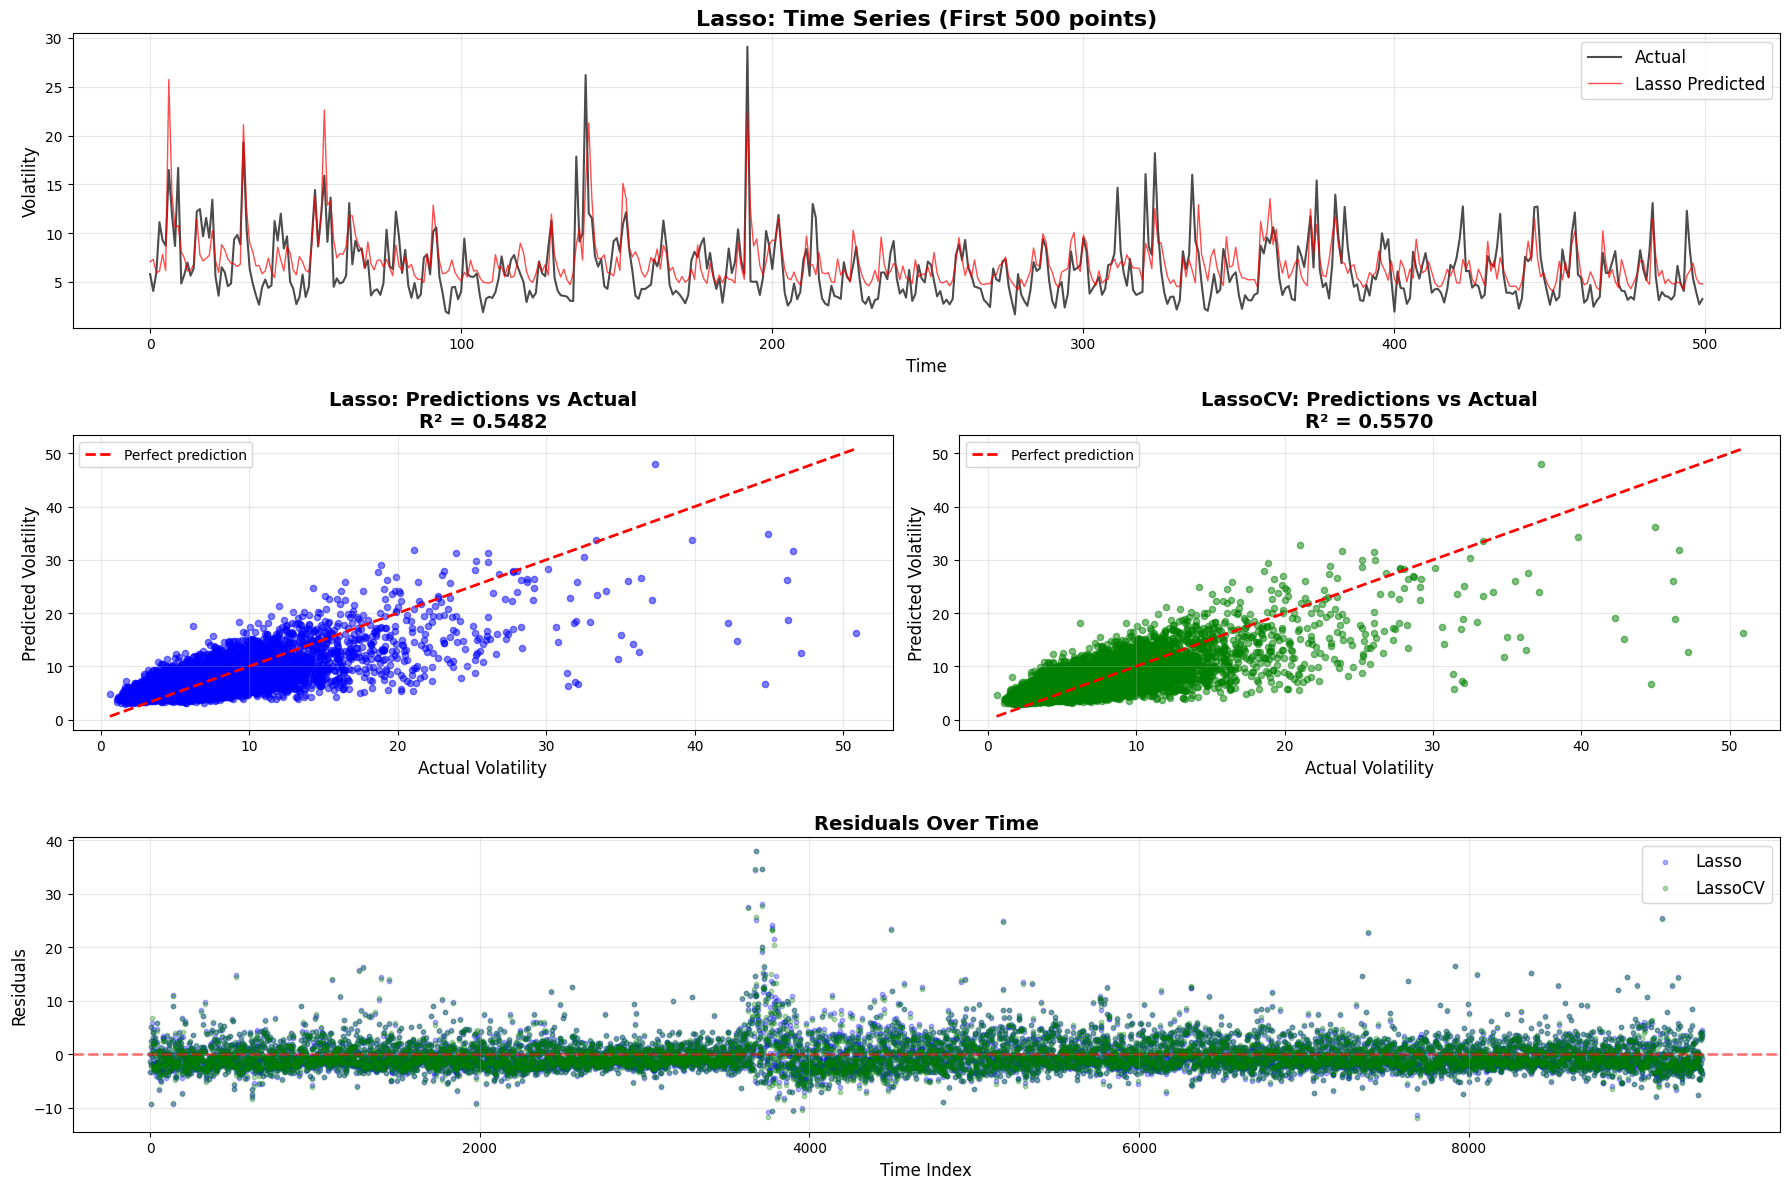

In [20]:
plot_model_results(results)

## XGBOOST

In [30]:
from XGBoostPDV import XGBoostPDV

# Prepare price data for XGBoost
prices = df['Close_last'].values

volatility = df[vol_title].values

xgb_model = XGBoostPDV(lookback=500, random_state=42)
xgb_model.fit(prices, volatility)

y_pred_xgb_full = xgb_model.predict(prices)

test_start_idx = len(prices) - len(results['data']['y_test'])
y_pred_xgb = pd.Series(
    y_pred_xgb_full[test_start_idx:],
    index=results['data']['y_test'].index,
    name='XGBoost_Prediction'
)
y_test = results['data']['y_test']
valid_mask = y_pred_xgb != 0

mse_xgb = mean_squared_error(y_test[valid_mask], y_pred_xgb[valid_mask])
r2_xgb = r2_score(y_test[valid_mask], y_pred_xgb[valid_mask])

print(f"\nXGBoost:")
print(f"  MSE:     {mse_xgb:.6e}")
print(f"  R² Test: {r2_xgb:.6f}")



XGBoost:
  MSE:     1.355303e+01
  R² Test: 0.287625
